In [ ]:
import pandas as pd
import numpy as np

import copy
import pickle
from datetime import datetime

import xgboost as xgb
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import median_absolute_error as MAPE
from sklearn.metrics import r2_score  as R2
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

from sklearn.metrics import r2_score

# Parameter tunning
import optuna
from sklearn.model_selection import KFold

import shap

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

Version: 1

Data description:
- 2056 properties
- ALL transations from 2015
- A single POI: near station

https://machinelearningmastery.com/xgboost-for-regression/
https://xgboost.readthedocs.io/en/stable/parameter.html


In [ ]:
def date_to_year(date_string):
    fmt = '%Y-%m-%d'
    return datetime.strptime(date_string,fmt).year

In [ ]:
Data = pd.read_csv('datasetV5.csv') 

In [ ]:
#PPData = pd.read_csv('PPstatistics.csv') 

In [ ]:
EPCData = pd.read_csv('EPCstatistics.csv') 

In [ ]:
#DataA=Data.merge(PPData, on='postcode')

In [ ]:
Data=Data.merge(EPCData, on='postcode')

No handles with labels found to put in legend.


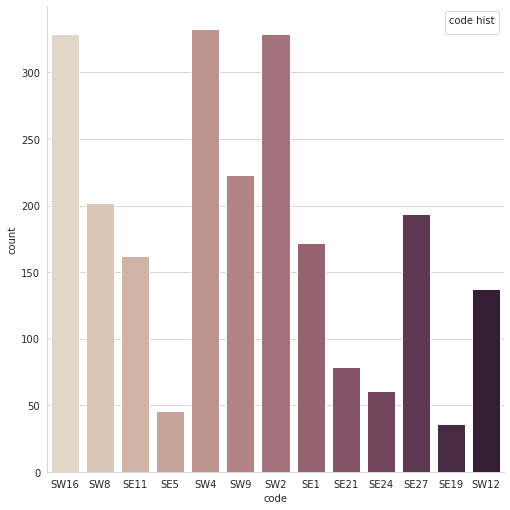

In [ ]:
sns.set_style('whitegrid')
sns.catplot(x="code", kind="count", palette="ch:.25", data=Data, height=7)
plt.legend(title='code hist')

In [ ]:
print(set(Data['code']))

{'SE19', 'SW12', 'SE24', 'SE1', 'SW9', 'SE5', 'SW2', 'SW4', 'SW16', 'SE21', 'SW8', 'SE11', 'SE27'}


In [ ]:
Data=Data[Data['PP_price']<1.000000e+06]
Data=Data[Data['PP_price']>10000]
#Data=Data[Data['code']=='SW4']

In [ ]:
len(Data)

2042

In [ ]:
Data['transferYear']=Data['PP_dateoftransfer'].apply(lambda x : date_to_year(x))
#Data['YearsInPast']=2022 - Data['transferYear']

In [ ]:
list(Data.columns)

['Unnamed: 0',
 'Unnamed: 0_x',
 'id',
 'PP_transactionid',
 'PP_price',
 'PP_dateoftransfer',
 'postcode',
 'PP_propertytype',
 'PP_oldnew',
 'PP_duration',
 'PP_categorytype',
 'PP_dateoftpriceransfer',
 'code',
 'yearmonth',
 'Unnamed: 0_y',
 'year',
 'month',
 'rate',
 'Year_1_Value',
 'Year_2_Value',
 'Year_2_growth',
 'Year_3_Value',
 'Year_3_growth',
 'Year_4_Value',
 'Year_4_growth',
 'Year_5_Value',
 'Year_5_growth',
 'population',
 'crimes_last_12m',
 'crimes_per_thousand',
 'crime_rating',
 'PublicOrder',
 'Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',
 'deprivation',
 'health',
 'age0_4',
 'age5_9',
 'age10_14',
 'age15_19',
 'age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age40_44',
 'age45_49',
 'age50_54',
 'age60_64',
 'age70_74',
 'age75_79',
 'age80_84',
 'age85_89',
 'proportion_with_degree',
 'vehicles_per_

### Crime

In [ ]:
Data['crime_total']=Data['PublicOrder']+Data['Burglary']+Data['Robbery']+Data['PossessionOfWeapons']+Data['BicycleTheft']+Data['AntiSocialBehaviour']+Data['Violence']+Data['Theft']+Data['Shoplifting']+Data['OtherCrime']+Data['Drugs']+Data['OtherTheft']+Data['VehicleCrime']+Data['CriminalDamage']

In [ ]:
Data['PublicOrder']=Data['PublicOrder']/Data['crime_total']

In [ ]:
Data['Burglary'] = Data['Burglary']/Data['crime_total']
Data['Robbery'] = Data['Robbery']/Data['crime_total']
Data['PossessionOfWeapons'] = Data['PossessionOfWeapons']/Data['crime_total']
Data['BicycleTheft'] = Data['BicycleTheft']/Data['crime_total']
Data['AntiSocialBehaviour'] = Data['AntiSocialBehaviour']/Data['crime_total']
Data['Violence'] = Data['Violence']/Data['crime_total']
Data['Theft'] = Data['Theft']/Data['crime_total']
Data['Shoplifting'] = Data['Shoplifting']/Data['crime_total']
Data['OtherCrime'] = Data['OtherCrime']/Data['crime_total']
Data['Drugs'] = Data['Drugs']/Data['crime_total']
Data['OtherTheft'] = Data['OtherTheft']/Data['crime_total']
Data['VehicleCrime'] = Data['VehicleCrime']/Data['crime_total']
Data['CriminalDamage'] = Data['CriminalDamage']/Data['crime_total']

Data['crime_Type_A'] = Data['Robbery']+Data['Drugs']+Data['PossessionOfWeapons']+Data['Burglary']+Data['OtherCrime']
Data['crime_Type_B'] = Data['OtherTheft'] + Data['Shoplifting'] + Data['Theft'] + Data['BicycleTheft']
Data['crime_Type_C'] = Data['CriminalDamage']+ Data['Violence'] + Data['AntiSocialBehaviour']
Data['crime_Type_D'] = Data['VehicleCrime']

In [ ]:
dropList=['Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',]
Data.drop(dropList, axis = 1, inplace = True)

### Age 

error: age55_59 age65-69

In [ ]:
Data['TotalModPop'] = Data['age20_24']+Data['age25_29']+Data['age30_34']+Data['age35_39']+Data['age40_44']+Data['age45_49']+Data['age45_49']+Data['age50_54']+Data['age60_64']
Data['age20_29'] = Data['age20_24']+Data['age25_29']
Data['age30_64'] = Data['age30_34']+Data['age35_39']+Data['age40_44']+Data['age45_49']+Data['age50_54']+Data['age60_64']
Data['age65_'] = Data['age70_74']+Data['age75_79']+Data['age80_84']+Data['age85_89']

In [ ]:
dropList=['age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age40_44',
 'age45_49',
 'age50_54',
 'age60_64',
 'age70_74',
 'age75_79',
 'age80_84',
 'age85_89']
Data.drop(dropList, axis = 1, inplace = True)

In [ ]:
Data['commute_method_public'] = Data['commute_method_train'] + Data['commute_method_bus'] + Data['commute_method_underground_light_rail']
Data['commute_method_private'] = Data['commute_method_motorcycle'] + Data['commute_method_taxi'] + Data['commute_method_car_driver'] + Data['commute_method_car_passenger']
Data['commute_method_open'] = Data['commute_method_foot']+Data['commute_method_bicycle']

In [ ]:
dropList=['commute_method_foot',
 'commute_method_bicycle',
 'commute_method_other',
 'commute_method_motorcycle',
 'commute_method_taxi',
 'commute_method_train',
 'commute_method_bus',
 'commute_method_underground_light_rail',
 'commute_method_car_driver',
 'commute_method_at_home',
 'commute_method_car_passenger',
]
Data.drop(dropList, axis = 1, inplace = True)

In [ ]:
Data['sold_70pc_disp']=-(Data['sold_70pc_rangeMIN']-Data['sold_70pc_rangeMAX'])/Data['sold_average']
Data['sold_80pc_disp']=-(Data['sold_80pc_rangeMIN']-Data['sold_80pc_rangeMAX'])/Data['sold_average']
Data['sold_90pc_disp']=-(Data['sold_90pc_rangeMIN']-Data['sold_90pc_rangeMAX'])/Data['sold_average']
Data['sold_100pc_disp']=-(Data['sold_100pc_rangeMIN']-Data['sold_100pc_rangeMAX'])/Data['sold_average']

In [ ]:
Data['sold_sqf_70pc_disp'] =-(Data['sold_sqf_70pc_rangeMIN']-Data['sold_sqf_70pc_rangeMAX'])/Data['sold_sqf_average']
Data['sold_sqf_80pc_disp'] =-(Data['sold_sqf_80pc_rangeMIN']-Data['sold_sqf_80pc_rangeMAX'])/Data['sold_sqf_average']
Data['sold_sqf_90pc_disp'] =-(Data['sold_sqf_90pc_rangeMIN']-Data['sold_sqf_90pc_rangeMAX'])/Data['sold_sqf_average']
Data['sold_sqf_100pc_disp'] =-(Data['sold_sqf_100pc_rangeMIN']-Data['sold_sqf_100pc_rangeMAX'])/Data['sold_sqf_average']

In [ ]:
Data['rents_70pc_disp'] = -(Data['rents_70pc_rangeMIN']-Data['rents_70pc_rangeMAX'])/Data['rents_average']
Data['rents_80pc_disp'] =-(Data['rents_80pc_rangeMIN']-Data['rents_80pc_rangeMAX'])/Data['rents_average']
Data['rents_90pc_disp'] =-(Data['rents_90pc_rangeMIN']-Data['rents_90pc_rangeMAX'])/Data['rents_average']
Data['rents_100pc_disp'] =-(Data['rents_100pc_rangeMIN']-Data['rents_100pc_rangeMAX'])/Data['rents_average']

In [ ]:
dropList=[ 'sold_points_analysed',
 'sold_70pc_rangeMIN',
 'sold_70pc_rangeMAX',
 'sold_80pc_rangeMIN',
 'sold_80pc_rangeMAX',
 'sold_90pc_rangeMIN',
 'sold_90pc_rangeMAX',
 'sold_sqf_points_analysed',
 'sold_sqf_70pc_rangeMIN',
 'sold_sqf_70pc_rangeMAX',
 'sold_sqf_80pc_rangeMIN',
 'sold_sqf_80pc_rangeMAX',
 'sold_sqf_90pc_rangeMIN',
 'sold_sqf_90pc_rangeMAX',
 'rents_points_analysed',
 'rents_70pc_rangeMIN',
 'rents_70pc_rangeMAX',
 'rents_80pc_rangeMIN',
 'rents_80pc_rangeMAX',
 'rents_90pc_rangeMIN',
 'rents_90pc_rangeMAX',]
Data.drop(dropList, axis = 1, inplace = True)

In [ ]:
### POI 


In [ ]:
Data['HperP']=Data['Households']/Data['Population']

In [ ]:
Data['post_Retailers_Density_500']= Data['post_Retailers_500']/500
Data['post_Retailers_Density_1000'] = (Data['post_Retailers_500']+Data['post_Retailers_1000'])/1000
Data['post_Retailers_Density_1500'] = (Data['post_Retailers_500']+Data['post_Retailers_1000']+Data['post_Retailers_1000.1'])/1500

In [ ]:
for name in [#'Restaurant',
'Manufacturers',
'Hotel',
'Importers',
'Mobile',
'Pub',
'Hospitals',
'Takeaway',
'schools',
'catering',
'shops',]:
    Data['post_'+ name +'_Density_500']= Data['post_'+ name +'_500']/500
    Data['post_'+ name +'_Density_1000'] = (Data['post_'+ name +'_500']+Data['post_'+ name +'_1000'])/1000
    Data['post_'+ name +'_Density_1500'] = (Data['post_'+ name +'_500']+Data['post_'+ name +'_1000']+Data['post_'+ name +'_1500'])/1500

In [ ]:
Data['post_Manufacturers_Density_500']= Data['post_Manufacturers_500']/500
Data['post_Manufacturers_Density_1000'] = (Data['post_Manufacturers_500']+Data['post_Manufacturers_1000'])/1000
Data['post_Manufacturers_Density_1500'] = (Data['post_Manufacturers_500']+Data['post_Manufacturers_1000']+Data['post_Manufacturers_1500'])/1500

In [ ]:
dropList=['post_Retailers_500',
 'post_Retailers_1000',
 'post_Retailers_1000.1',
 'post_Restaurant_500',
 'post_Restaurant_1000',
 'post_Restaurant_1500',
 'post_Manufacturers_500',
 'post_Manufacturers_1000',
 'post_Manufacturers_1500',
 'post_Hotel_500',
 'post_Hotel_1000',
 'post_Hotel_1500',
 'post_Importers_500',
 'post_Importers_1000',
 'post_Importers_1500',
 'post_Mobile_500',
 'post_Mobile_1000',
 'post_Mobile_1500',
 'post_Pub_500',
 'post_Pub_1000',
 'post_Pub_1500',
 'post_Hospitals_500',
 'post_Hospitals_1000',
 'post_Hospitals_1500',
 'post_Takeaway_500',
 'post_Takeaway_1000',
 'post_Takeaway_1500',
 'post_School_500',
 'post_School_1000',
 'post_School_1500',
 'post_catering_500',
 'post_catering_1000',
 'post_catering_1500',
 'post_shops_500',
 'post_shops_1000',
 'post_shops_1500',
 'post_schools_500',
 'post_schools_1000',
 'post_schools_1500',]
Data.drop(dropList, axis = 1, inplace = True)

In [ ]:
total = Data['construction_before_1900']+Data['construction_1900_1929']+Data['construction_1930_1949']+Data['construction_1950_1966']+Data['construction_1967_1975']+Data['construction_1976_1982']+Data['construction_1983_1990']+Data['construction_1991_1995']+Data['construction_1996_2002']+Data['construction_2003_2006']+Data['construction_2007_2011']+Data['construction_2012_onwards']

Data['construction_before_1900']=Data['construction_before_1900']/total
Data['construction_1900_1929']=Data['construction_1900_1929']/total
Data['construction_1930_1949']=Data['construction_1930_1949']/total
Data['construction_1950_1966']=Data['construction_1950_1966']/total
Data['construction_1967_1975']=Data['construction_1967_1975']/total
Data['construction_1976_1982']=Data['construction_1976_1982']/total
Data['construction_1983_1990']=Data['construction_1983_1990']/total
Data['construction_1991_1995']=Data['construction_1991_1995']/total
Data['construction_1996_2002']=Data['construction_1996_2002']/total
Data['construction_2003_2006']=Data['construction_2003_2006']/total
Data['construction_2007_2011']=Data['construction_2007_2011']/total
Data['construction_2012_onwards']=Data['construction_2012_onwards']/total

Data['count'] = Data['count']/Data['Households']

No handles with labels found to put in legend.


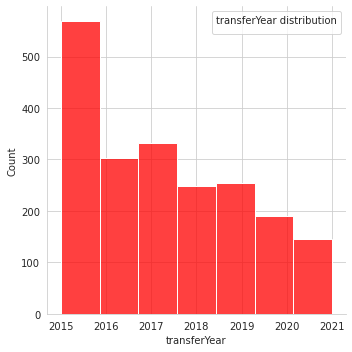

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['transferYear'], kde = False, color ='red', bins = 7)
plt.legend(title='transferYear distribution')

No handles with labels found to put in legend.


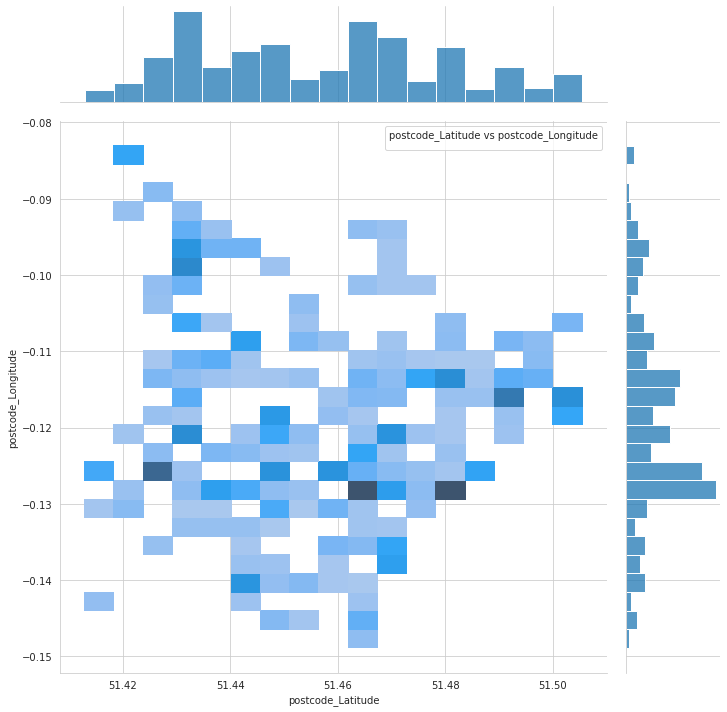

In [ ]:
sns.set_style('whitegrid')
sns.jointplot(x ='postcode_Latitude', y ='postcode_Longitude', data = Data, kind ='hist',height=10)
plt.legend(title='postcode_Latitude vs postcode_Longitude')

No handles with labels found to put in legend.


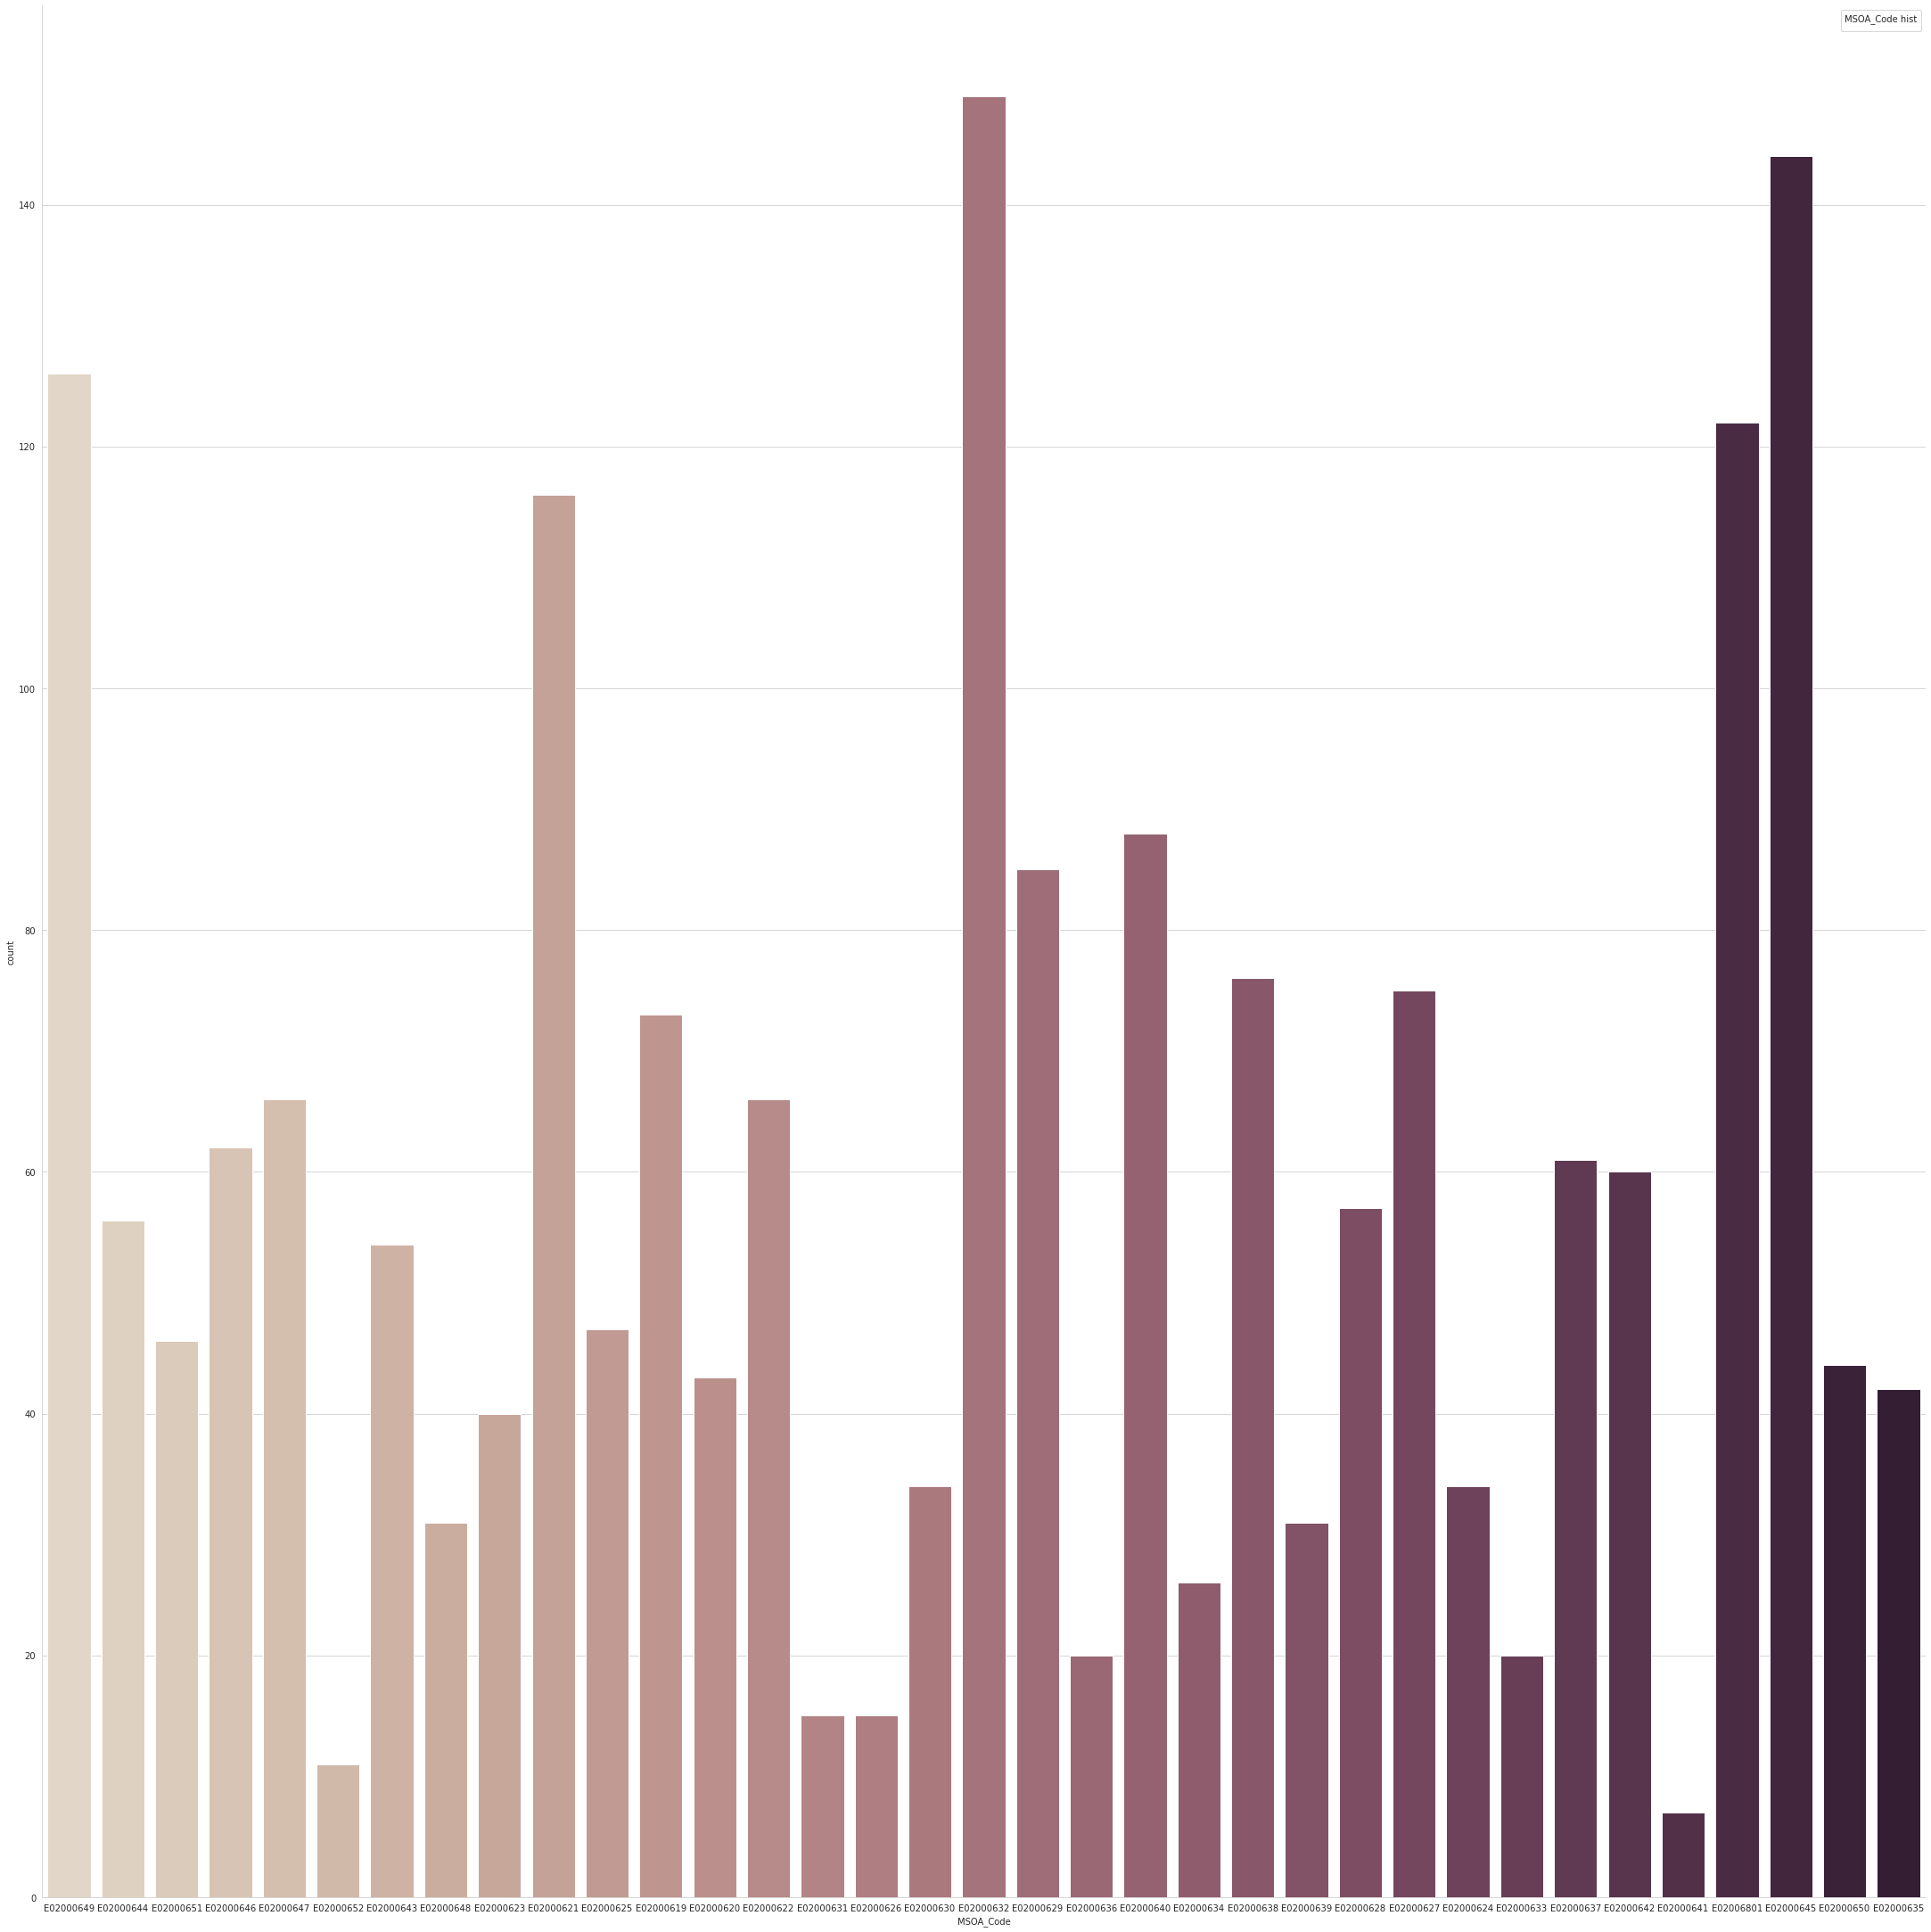

In [ ]:
sns.set_style('whitegrid')
sns.catplot(x="MSOA_Code", kind="count", palette="ch:.25", data=Data, height=30)
plt.legend(title='MSOA_Code hist')

No handles with labels found to put in legend.


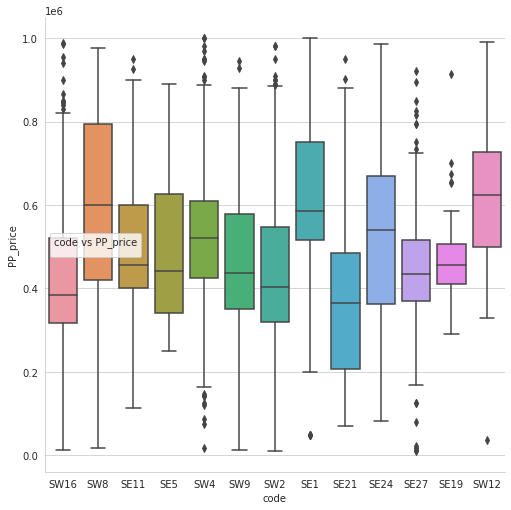

In [ ]:
sns.catplot(x="code", y="PP_price",  kind="box", data=Data,height=7)
plt.legend(title='code vs PP_price')

No handles with labels found to put in legend.


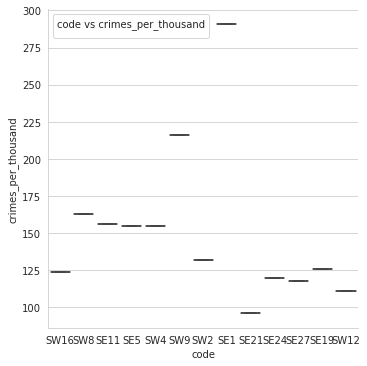

In [ ]:
sns.catplot(x="code", y="crimes_per_thousand",  kind="box", data=Data)
plt.legend(title='code vs crimes_per_thousand')

Removing inrelevant attributes

In [ ]:
dropList=['Unnamed: 0','Unnamed: 0_x','Unnamed: 0_y','year','month','yearmonth','id','PP_dateoftransfer', 'PP_dateoftpriceransfer','transferYear','postcode','code',
         'area','postcode_Latitude','postcode_Longitude','MSOA_Code','LSOA_Code','PP_dateoftransfer','PP_transactionid',
          ]
Data.drop(dropList, axis = 1, inplace = True)

Adding the price paid by sq

No handles with labels found to put in legend.


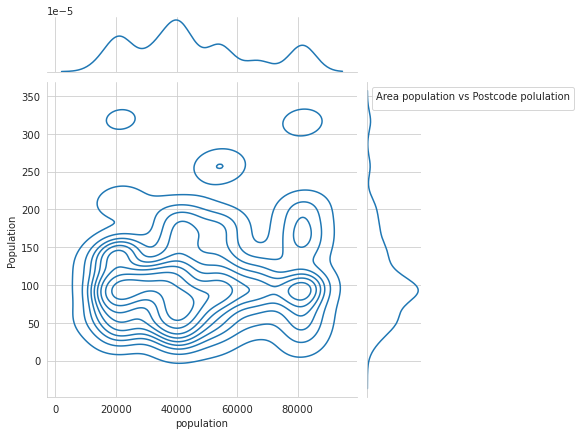

In [ ]:
sns.set_style('whitegrid')
sns.jointplot(x ='population', y ='Population', data = Data, kind ='kde')
plt.legend(title='Area population vs Postcode polulation')

No handles with labels found to put in legend.


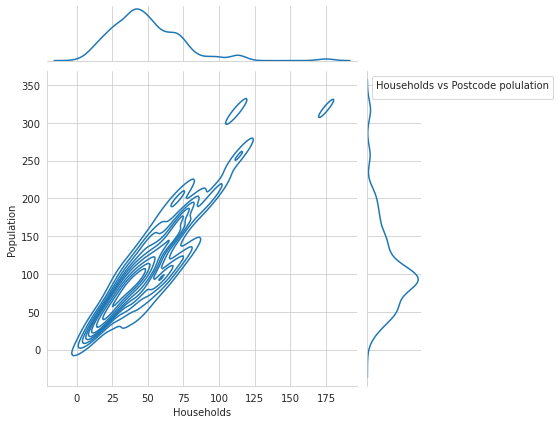

In [ ]:
sns.set_style('whitegrid')
sns.jointplot(x ='Households', y ='Population', data = Data, kind ='kde')
plt.legend(title='Households vs Postcode polulation')

### sq_PricePaid statistics

In [ ]:
Data['PP_price'].describe()

count      2042.000000
mean     492221.221352
std      191610.627915
min       10200.000000
25%      363062.500000
50%      465000.000000
75%      605000.000000
max      999950.000000
Name: PP_price, dtype: float64

No handles with labels found to put in legend.


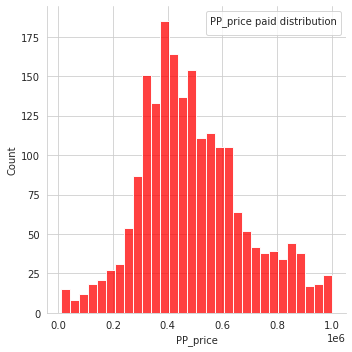

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['PP_price'], kde = False, color ='red', bins = 30)
plt.legend(title='PP_price paid distribution')

No handles with labels found to put in legend.


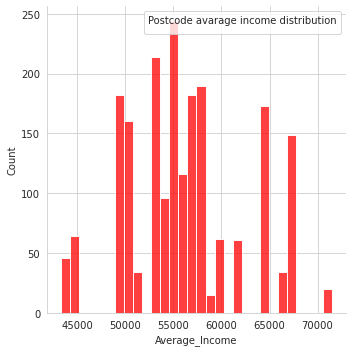

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Average_Income'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode avarage income distribution')

No handles with labels found to put in legend.


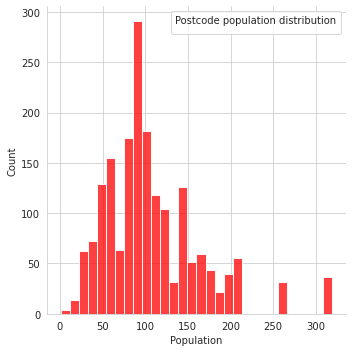

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Population'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode population distribution')

No handles with labels found to put in legend.


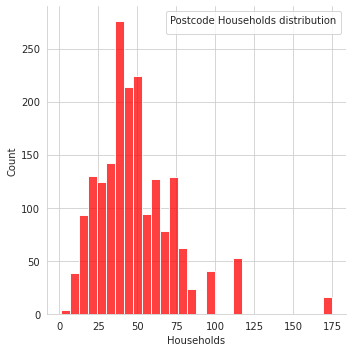

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Households'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode Households distribution')

No handles with labels found to put in legend.


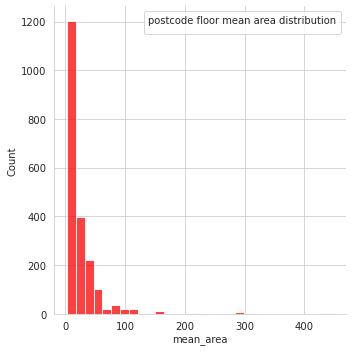

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['mean_area'], kde = False, color ='red', bins = 30)
plt.legend(title='postcode floor mean area distribution')

### Categorical attribute binarization

In [ ]:

lbl = preprocessing.LabelEncoder()

catData = ['PP_propertytype', 'PP_oldnew', 'PP_duration', 'PP_categorytype', 'crime_rating', 'ptal', 'flood_risk','restaurant_rating']
for att in catData:
    unique_classes = Data[att].unique()
    one_hot = pd.get_dummies(unique_classes, prefix=att,dummy_na=True, columns = [att])
    one_hot[att] = unique_classes
    Data = Data.merge(one_hot, on = [att], how='left')
    Data = Data.drop(columns = [att])

In [ ]:
list(Data.columns)

['PP_price',
 'rate',
 'Year_1_Value',
 'Year_2_Value',
 'Year_2_growth',
 'Year_3_Value',
 'Year_3_growth',
 'Year_4_Value',
 'Year_4_growth',
 'Year_5_Value',
 'Year_5_growth',
 'population',
 'crimes_last_12m',
 'crimes_per_thousand',
 'PublicOrder',
 'deprivation',
 'health',
 'age0_4',
 'age5_9',
 'age10_14',
 'age15_19',
 'proportion_with_degree',
 'vehicles_per_household',
 'social_grade_ab',
 'social_grade_de',
 'social_grade_c1',
 'social_grade_c2',
 'total_for_rent',
 'transactions_per_month',
 'turnover_per_month',
 'months_of_inventory',
 'days_on_market',
 'sold_average',
 'sold_100pc_rangeMIN',
 'sold_100pc_rangeMAX',
 'sold_sqf_average',
 'sold_sqf_100pc_rangeMIN',
 'sold_sqf_100pc_rangeMAX',
 'rents_average',
 'rents_100pc_rangeMIN',
 'rents_100pc_rangeMAX',
 'mean_area',
 'Distance_to_station',
 'Average_Income',
 'Population',
 'Households',
 'restaurant_hygiene',
 'restaurant_bad',
 'exist_Retailers',
 'exist_Restaurant',
 'exist_Manufacturers',
 'exist_Hotel',
 'exi

### Define sq_price as the model goal 

In [ ]:
Data['price'] = Data['PP_price']+Data['PP_price']*Data['rate']
Data.drop(['PP_price','rate'], axis = 1, inplace = True)

In [ ]:
# Split data
X, y = Data.iloc[:, :-1], Data.iloc[:, -1]

### Parametters tunning

In [ ]:
def objective(trial, X, y, kf):
    n_estimators = trial.suggest_int('n_estimators', 206, 512)
    learning_rate =trial.suggest_uniform('learning_rate', 0, 0.1) 
    #max_depth = trial.suggest_int('max_depth', 3, 10)
    min_split_loss = trial.suggest_uniform('min_split_loss', 0, 2.5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0, 10)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0, 10)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1)
    subsample = trial.suggest_uniform('subsample', 0.5, 1)
    eta = trial.suggest_uniform('eta', 0, 1)
    
    model = xg.XGBRegressor(n_estimators=n_estimators,
                          #max_depth=max_depth,
                          learning_rate=learning_rate,
                          min_split_loss=min_split_loss,
                          min_child_weight=min_child_weight,
                          reg_lambda=reg_lambda,
                          reg_alpha=reg_alpha,
                          colsample_bytree=colsample_bytree,
                          subsample=subsample,
                          eta=eta,
                          objective='reg:squarederror', 
                          booster='gbtree',
                          seed=42,
                          n_jobs=3)
    
    
    test_score = []
    
    step = 0
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        test_score.append(MAE(y_test, y_pred)/492221.221352*100)
        #test_score.append(R2(y_test, y_pred))
        
        trial.report(np.mean(test_score), step)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        step+=1

    return np.mean(test_score)



kf = KFold(n_splits=4, shuffle=True, random_state=42)

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.SuccessiveHalvingPruner())

study.optimize(lambda trial: objective(trial, X, y, kf), timeout=30*60, n_jobs=1)

study.best_params 

[I 2021-12-04 02:21:20,290] A new study created in memory with name: no-name-a22dc759-eb40-4870-97f0-091027f603e0
[I 2021-12-04 02:21:25,667] Trial 0 finished with value: 19.772664422679348 and parameters: {'n_estimators': 377, 'learning_rate': 0.09347672671587676, 'min_split_loss': 0.042301929740893585, 'min_child_weight': 6, 'reg_lambda': 5.1692683189377195, 'reg_alpha': 0.06930068873493345, 'colsample_bytree': 0.6094206045624153, 'subsample': 0.5837715703341652, 'eta': 0.30608919373996224}. Best is trial 0 with value: 19.772664422679348.
[I 2021-12-04 02:21:28,989] Trial 1 finished with value: 19.42561199676983 and parameters: {'n_estimators': 229, 'learning_rate': 0.04975441619583407, 'min_split_loss': 0.5049488798556678, 'min_child_weight': 7, 'reg_lambda': 4.807431533185271, 'reg_alpha': 1.8922977595527168, 'colsample_bytree': 0.8445154037876658, 'subsample': 0.9818448748336965, 'eta': 0.6269461336108298}. Best is trial 1 with value: 19.42561199676983.
[I 2021-12-04 02:21:36,308]

[I 2021-12-04 02:23:34,028] Trial 46 finished with value: 19.312596608819266 and parameters: {'n_estimators': 235, 'learning_rate': 0.03917773299396884, 'min_split_loss': 0.7367149900926437, 'min_child_weight': 3, 'reg_lambda': 7.544400363794512, 'reg_alpha': 5.146256312757879, 'colsample_bytree': 0.6160935725720937, 'subsample': 0.6272732596363737, 'eta': 0.23625426231386948}. Best is trial 41 with value: 19.204466145287356.
[I 2021-12-04 02:23:36,330] Trial 47 pruned. 
[I 2021-12-04 02:23:39,008] Trial 48 pruned. 
[I 2021-12-04 02:23:40,731] Trial 49 pruned. 
[I 2021-12-04 02:23:42,600] Trial 50 pruned. 
[I 2021-12-04 02:23:45,337] Trial 51 finished with value: 19.209962245180655 and parameters: {'n_estimators': 208, 'learning_rate': 0.026692997036058822, 'min_split_loss': 0.30728409598862644, 'min_child_weight': 3, 'reg_lambda': 7.919394807988346, 'reg_alpha': 5.999589709156719, 'colsample_bytree': 0.6498807838155548, 'subsample': 0.9069425289437432, 'eta': 0.055810087576326384}. Be

[I 2021-12-04 02:25:03,957] Trial 86 finished with value: 19.19543916678888 and parameters: {'n_estimators': 246, 'learning_rate': 0.02388824186642496, 'min_split_loss': 0.19066214126587527, 'min_child_weight': 3, 'reg_lambda': 8.339342042341173, 'reg_alpha': 3.045009921162902, 'colsample_bytree': 0.5185396358882783, 'subsample': 0.8390334761620866, 'eta': 0.1024847979845512}. Best is trial 77 with value: 19.184174978941563.
[I 2021-12-04 02:25:07,195] Trial 87 finished with value: 19.17455858770623 and parameters: {'n_estimators': 284, 'learning_rate': 0.019503251333318202, 'min_split_loss': 0.5053647428260951, 'min_child_weight': 3, 'reg_lambda': 9.569706925110188, 'reg_alpha': 3.0787599565451242, 'colsample_bytree': 0.5188382032146398, 'subsample': 0.8416233645726259, 'eta': 0.09621210728217068}. Best is trial 87 with value: 19.17455858770623.
[I 2021-12-04 02:25:10,554] Trial 88 finished with value: 19.20333979988618 and parameters: {'n_estimators': 285, 'learning_rate': 0.02380561

[I 2021-12-04 02:26:30,227] Trial 119 finished with value: 19.215086820719186 and parameters: {'n_estimators': 301, 'learning_rate': 0.017755971319925127, 'min_split_loss': 0.6548029773667926, 'min_child_weight': 2, 'reg_lambda': 9.123264890716586, 'reg_alpha': 1.885530092529367, 'colsample_bytree': 0.5277907789996116, 'subsample': 0.8196084850382299, 'eta': 0.03885525900175444}. Best is trial 100 with value: 19.15667347533789.
[I 2021-12-04 02:26:32,040] Trial 120 pruned. 
[I 2021-12-04 02:26:35,517] Trial 121 finished with value: 19.184941710158945 and parameters: {'n_estimators': 294, 'learning_rate': 0.020860249083406522, 'min_split_loss': 0.3930341813013477, 'min_child_weight': 3, 'reg_lambda': 8.558792727387942, 'reg_alpha': 2.5102250761468454, 'colsample_bytree': 0.5383568980677587, 'subsample': 0.8368876253030958, 'eta': 0.08956315667995349}. Best is trial 100 with value: 19.15667347533789.
[I 2021-12-04 02:26:37,338] Trial 122 pruned. 
[I 2021-12-04 02:26:39,005] Trial 123 pru

[I 2021-12-04 02:28:03,905] Trial 157 finished with value: 19.173387471271067 and parameters: {'n_estimators': 304, 'learning_rate': 0.015494859087889652, 'min_split_loss': 0.9727885794471508, 'min_child_weight': 8, 'reg_lambda': 8.6308637335289, 'reg_alpha': 2.513246440610865, 'colsample_bytree': 0.5719962744025421, 'subsample': 0.9751907754618326, 'eta': 0.3411466080553161}. Best is trial 100 with value: 19.15667347533789.
[I 2021-12-04 02:28:07,199] Trial 158 finished with value: 19.122564282356933 and parameters: {'n_estimators': 304, 'learning_rate': 0.016615359726339214, 'min_split_loss': 0.8917298997575758, 'min_child_weight': 8, 'reg_lambda': 8.443568124125273, 'reg_alpha': 2.7441138113688934, 'colsample_bytree': 0.5751266569078598, 'subsample': 0.9897681718857586, 'eta': 0.3250474721452384}. Best is trial 158 with value: 19.122564282356933.
[I 2021-12-04 02:28:10,535] Trial 159 finished with value: 19.194883181041398 and parameters: {'n_estimators': 304, 'learning_rate': 0.015

[I 2021-12-04 02:29:18,678] Trial 182 finished with value: 19.143594376904748 and parameters: {'n_estimators': 339, 'learning_rate': 0.018105013255899072, 'min_split_loss': 1.0684020774803797, 'min_child_weight': 9, 'reg_lambda': 8.373129606503982, 'reg_alpha': 3.338789969169281, 'colsample_bytree': 0.5886668016361799, 'subsample': 0.9651987419266641, 'eta': 0.4074863269669119}. Best is trial 173 with value: 19.119781481938134.
[I 2021-12-04 02:29:22,429] Trial 183 finished with value: 19.140715161364017 and parameters: {'n_estimators': 338, 'learning_rate': 0.017440677968502728, 'min_split_loss': 1.2683410998188882, 'min_child_weight': 9, 'reg_lambda': 8.082080414430875, 'reg_alpha': 3.363235359936355, 'colsample_bytree': 0.5843707402771341, 'subsample': 0.9628479417575383, 'eta': 0.3984873694528593}. Best is trial 173 with value: 19.119781481938134.
[I 2021-12-04 02:29:26,332] Trial 184 finished with value: 19.146675350976018 and parameters: {'n_estimators': 353, 'learning_rate': 0.0

[I 2021-12-04 02:30:40,483] Trial 204 finished with value: 19.15274698298046 and parameters: {'n_estimators': 358, 'learning_rate': 0.01927696438958546, 'min_split_loss': 1.2260015511189999, 'min_child_weight': 9, 'reg_lambda': 7.253936598553149, 'reg_alpha': 3.7430951340489926, 'colsample_bytree': 0.6407663618767019, 'subsample': 0.9806520886632476, 'eta': 0.427864882152848}. Best is trial 190 with value: 19.108973536506507.
[I 2021-12-04 02:30:44,647] Trial 205 finished with value: 19.132337376611172 and parameters: {'n_estimators': 372, 'learning_rate': 0.019258942753271932, 'min_split_loss': 1.312201678609683, 'min_child_weight': 9, 'reg_lambda': 6.726346658143234, 'reg_alpha': 3.5288451391873332, 'colsample_bytree': 0.6203327180331349, 'subsample': 0.9988432071736668, 'eta': 0.5350777649715962}. Best is trial 190 with value: 19.108973536506507.
[I 2021-12-04 02:30:46,759] Trial 206 pruned. 
[I 2021-12-04 02:30:48,867] Trial 207 pruned. 
[I 2021-12-04 02:30:52,915] Trial 208 finish

[I 2021-12-04 02:32:16,272] Trial 231 finished with value: 19.1213891538138 and parameters: {'n_estimators': 369, 'learning_rate': 0.015958398053088334, 'min_split_loss': 1.296066451715792, 'min_child_weight': 10, 'reg_lambda': 7.146817742237137, 'reg_alpha': 4.253400895593571, 'colsample_bytree': 0.6389108572177096, 'subsample': 0.9999648902284313, 'eta': 0.47472756095952084}. Best is trial 211 with value: 19.100278565795108.
[I 2021-12-04 02:32:20,272] Trial 232 finished with value: 19.139461606021644 and parameters: {'n_estimators': 345, 'learning_rate': 0.01593883138345049, 'min_split_loss': 1.3139771870644459, 'min_child_weight': 10, 'reg_lambda': 6.817165291013709, 'reg_alpha': 4.297882349196523, 'colsample_bytree': 0.6382623330791528, 'subsample': 0.9838433209219924, 'eta': 0.46652474154253665}. Best is trial 211 with value: 19.100278565795108.
[I 2021-12-04 02:32:25,003] Trial 233 finished with value: 19.15586302815864 and parameters: {'n_estimators': 399, 'learning_rate': 0.01

[I 2021-12-04 02:33:46,396] Trial 255 pruned. 
[I 2021-12-04 02:33:50,555] Trial 256 finished with value: 19.11777443395521 and parameters: {'n_estimators': 380, 'learning_rate': 0.01481317410102068, 'min_split_loss': 1.597334196635814, 'min_child_weight': 10, 'reg_lambda': 7.868685751750137, 'reg_alpha': 2.7056587356535298, 'colsample_bytree': 0.5999989081145156, 'subsample': 0.9905561466751466, 'eta': 0.6110094844104759}. Best is trial 211 with value: 19.100278565795108.
[I 2021-12-04 02:33:52,563] Trial 257 pruned. 
[I 2021-12-04 02:33:56,798] Trial 258 finished with value: 19.138547203906832 and parameters: {'n_estimators': 379, 'learning_rate': 0.013668701810668435, 'min_split_loss': 1.4333295657101617, 'min_child_weight': 10, 'reg_lambda': 7.458844862302563, 'reg_alpha': 2.732567683929994, 'colsample_bytree': 0.6053007947030564, 'subsample': 0.9728191030096693, 'eta': 0.6462469791482328}. Best is trial 211 with value: 19.100278565795108.
[I 2021-12-04 02:34:00,880] Trial 259 fini

[I 2021-12-04 02:35:33,520] Trial 289 finished with value: 19.103603963608094 and parameters: {'n_estimators': 366, 'learning_rate': 0.016529435184207863, 'min_split_loss': 0.9812671309025683, 'min_child_weight': 9, 'reg_lambda': 8.04942096932722, 'reg_alpha': 3.905009351686729, 'colsample_bytree': 0.5775041628817352, 'subsample': 0.9893349894281172, 'eta': 0.42826548954089294}. Best is trial 274 with value: 19.076070742719853.
[I 2021-12-04 02:35:37,469] Trial 290 finished with value: 19.138053986042895 and parameters: {'n_estimators': 365, 'learning_rate': 0.016809961847067668, 'min_split_loss': 0.9954604102358325, 'min_child_weight': 9, 'reg_lambda': 8.049592467746411, 'reg_alpha': 3.9114971508648106, 'colsample_bytree': 0.5755467708527875, 'subsample': 0.9803462185171269, 'eta': 0.4335160470121138}. Best is trial 274 with value: 19.076070742719853.
[I 2021-12-04 02:35:39,401] Trial 291 pruned. 
[I 2021-12-04 02:35:43,437] Trial 292 finished with value: 19.11497500530777 and paramet

[I 2021-12-04 02:37:00,323] Trial 317 finished with value: 19.088461947657123 and parameters: {'n_estimators': 343, 'learning_rate': 0.015369067881507456, 'min_split_loss': 2.2045391004307278, 'min_child_weight': 9, 'reg_lambda': 7.639407786811812, 'reg_alpha': 4.9707673918529816, 'colsample_bytree': 0.556980698018859, 'subsample': 0.9993843707505375, 'eta': 0.4561361916052287}. Best is trial 297 with value: 19.07268232632289.
[I 2021-12-04 02:37:02,067] Trial 318 pruned. 
[I 2021-12-04 02:37:04,240] Trial 319 pruned. 
[I 2021-12-04 02:37:06,031] Trial 320 pruned. 
[I 2021-12-04 02:37:09,820] Trial 321 finished with value: 19.12358407137164 and parameters: {'n_estimators': 352, 'learning_rate': 0.015416715059445965, 'min_split_loss': 2.216817168699637, 'min_child_weight': 9, 'reg_lambda': 7.981591528577663, 'reg_alpha': 4.430135004758003, 'colsample_bytree': 0.5678349930315938, 'subsample': 0.982925089148457, 'eta': 0.40529532861784495}. Best is trial 297 with value: 19.07268232632289.

[I 2021-12-04 02:38:36,983] Trial 351 finished with value: 19.15131910580447 and parameters: {'n_estimators': 343, 'learning_rate': 0.014077482438138651, 'min_split_loss': 2.3220633091337586, 'min_child_weight': 9, 'reg_lambda': 8.548505407547902, 'reg_alpha': 4.327142270632116, 'colsample_bytree': 0.5522910622689631, 'subsample': 0.9824032916602847, 'eta': 0.38066120143967075}. Best is trial 297 with value: 19.07268232632289.
[I 2021-12-04 02:38:40,723] Trial 352 finished with value: 19.138625210504305 and parameters: {'n_estimators': 341, 'learning_rate': 0.016612216304772845, 'min_split_loss': 2.4620182970762015, 'min_child_weight': 8, 'reg_lambda': 8.28534466975343, 'reg_alpha': 4.112935341102538, 'colsample_bytree': 0.5843059185225429, 'subsample': 0.9888323703217191, 'eta': 0.4211339853628543}. Best is trial 297 with value: 19.07268232632289.
[I 2021-12-04 02:38:42,588] Trial 353 pruned. 
[I 2021-12-04 02:38:44,439] Trial 354 pruned. 
[I 2021-12-04 02:38:48,188] Trial 355 finishe

[I 2021-12-04 02:40:11,566] Trial 386 pruned. 
[I 2021-12-04 02:40:15,291] Trial 387 finished with value: 19.120223562693873 and parameters: {'n_estimators': 343, 'learning_rate': 0.018374522901283365, 'min_split_loss': 1.9271864352557788, 'min_child_weight': 9, 'reg_lambda': 7.477140287782404, 'reg_alpha': 5.19148572758545, 'colsample_bytree': 0.5805458142630093, 'subsample': 0.9903665095081998, 'eta': 0.4030152255769454}. Best is trial 297 with value: 19.07268232632289.
[I 2021-12-04 02:40:17,261] Trial 388 pruned. 
[I 2021-12-04 02:40:21,040] Trial 389 finished with value: 19.133451790148257 and parameters: {'n_estimators': 350, 'learning_rate': 0.013562985686930266, 'min_split_loss': 2.481155090025982, 'min_child_weight': 9, 'reg_lambda': 8.385298911493301, 'reg_alpha': 4.595911445739003, 'colsample_bytree': 0.5885795854133098, 'subsample': 0.9992906472228683, 'eta': 0.3891503057620479}. Best is trial 297 with value: 19.07268232632289.
[I 2021-12-04 02:40:22,959] Trial 390 pruned. 

[I 2021-12-04 02:41:32,479] Trial 413 pruned. 
[I 2021-12-04 02:41:36,074] Trial 414 finished with value: 19.100961507505446 and parameters: {'n_estimators': 347, 'learning_rate': 0.020496399479667554, 'min_split_loss': 1.8627081701774852, 'min_child_weight': 9, 'reg_lambda': 7.740163045638127, 'reg_alpha': 4.451675585111209, 'colsample_bytree': 0.5546631903866192, 'subsample': 0.9996543037754239, 'eta': 0.43714019452674324}. Best is trial 297 with value: 19.07268232632289.
[I 2021-12-04 02:41:38,019] Trial 415 pruned. 
[I 2021-12-04 02:41:41,547] Trial 416 finished with value: 19.120791140351344 and parameters: {'n_estimators': 335, 'learning_rate': 0.014597095746900903, 'min_split_loss': 1.759052392739555, 'min_child_weight': 9, 'reg_lambda': 8.206205075741785, 'reg_alpha': 4.263186595725929, 'colsample_bytree': 0.5615253048949986, 'subsample': 0.9997260635540322, 'eta': 0.46124024043625445}. Best is trial 297 with value: 19.07268232632289.
[I 2021-12-04 02:41:43,349] Trial 417 prune

[I 2021-12-04 02:43:14,213] Trial 449 finished with value: 19.14449814777871 and parameters: {'n_estimators': 342, 'learning_rate': 0.014150376729720339, 'min_split_loss': 1.958334241244229, 'min_child_weight': 9, 'reg_lambda': 8.024994164303894, 'reg_alpha': 4.581649846563737, 'colsample_bytree': 0.5929196261557145, 'subsample': 0.9903146852435676, 'eta': 0.3521733054482641}. Best is trial 431 with value: 19.066072508424753.
[I 2021-12-04 02:43:16,114] Trial 450 pruned. 
[I 2021-12-04 02:43:18,366] Trial 451 pruned. 
[I 2021-12-04 02:43:20,259] Trial 452 pruned. 
[I 2021-12-04 02:43:24,011] Trial 453 finished with value: 19.136862379461 and parameters: {'n_estimators': 353, 'learning_rate': 0.01561577690759938, 'min_split_loss': 2.059636594381909, 'min_child_weight': 9, 'reg_lambda': 8.176366537241574, 'reg_alpha': 4.774758125002019, 'colsample_bytree': 0.5581465909177897, 'subsample': 0.9757623388672811, 'eta': 0.4037811041954399}. Best is trial 431 with value: 19.066072508424753.
[I

[I 2021-12-04 02:45:01,124] Trial 490 pruned. 
[I 2021-12-04 02:45:02,985] Trial 491 pruned. 
[I 2021-12-04 02:45:04,954] Trial 492 pruned. 
[I 2021-12-04 02:45:08,830] Trial 493 finished with value: 19.14200319858621 and parameters: {'n_estimators': 357, 'learning_rate': 0.02143617542612546, 'min_split_loss': 2.191799890634569, 'min_child_weight': 9, 'reg_lambda': 7.967552537956473, 'reg_alpha': 4.873441619910543, 'colsample_bytree': 0.5838531695659998, 'subsample': 0.9904800542028398, 'eta': 0.40284998859592586}. Best is trial 431 with value: 19.066072508424753.
[I 2021-12-04 02:45:10,769] Trial 494 pruned. 
[I 2021-12-04 02:45:14,475] Trial 495 finished with value: 19.08955200397567 and parameters: {'n_estimators': 350, 'learning_rate': 0.017748617767760773, 'min_split_loss': 1.8974552889408947, 'min_child_weight': 9, 'reg_lambda': 8.191636933048489, 'reg_alpha': 4.420281151755721, 'colsample_bytree': 0.5680418557348105, 'subsample': 0.999644823093627, 'eta': 0.4218296294336575}. Be

[I 2021-12-04 02:46:41,680] Trial 526 pruned. 
[I 2021-12-04 02:46:44,048] Trial 527 pruned. 
[I 2021-12-04 02:46:45,860] Trial 528 pruned. 
[I 2021-12-04 02:46:49,592] Trial 529 finished with value: 19.108158652649905 and parameters: {'n_estimators': 355, 'learning_rate': 0.01673026785024445, 'min_split_loss': 1.8182458018914935, 'min_child_weight': 9, 'reg_lambda': 7.811572985818009, 'reg_alpha': 5.56432659628797, 'colsample_bytree': 0.5662332463246529, 'subsample': 0.9997268441450019, 'eta': 0.37343048996887945}. Best is trial 431 with value: 19.066072508424753.
[I 2021-12-04 02:46:51,497] Trial 530 pruned. 
[I 2021-12-04 02:46:55,291] Trial 531 finished with value: 19.124810124368775 and parameters: {'n_estimators': 362, 'learning_rate': 0.015346451647746685, 'min_split_loss': 2.0094263223314672, 'min_child_weight': 9, 'reg_lambda': 7.626310146742254, 'reg_alpha': 3.986022554273789, 'colsample_bytree': 0.554878781496935, 'subsample': 0.9856686513747104, 'eta': 0.4040411716843169}. 

[I 2021-12-04 02:48:53,523] Trial 581 pruned. 
[I 2021-12-04 02:48:57,401] Trial 582 finished with value: 19.091340516510083 and parameters: {'n_estimators': 375, 'learning_rate': 0.016684105546357478, 'min_split_loss': 2.1271647959787163, 'min_child_weight': 9, 'reg_lambda': 8.021861397914936, 'reg_alpha': 5.260491035167465, 'colsample_bytree': 0.5509406357027993, 'subsample': 0.9997926828988317, 'eta': 0.39141046129149076}. Best is trial 431 with value: 19.066072508424753.
[I 2021-12-04 02:49:01,177] Trial 583 finished with value: 19.096876571858363 and parameters: {'n_estimators': 377, 'learning_rate': 0.017088986380876123, 'min_split_loss': 2.1524873596844536, 'min_child_weight': 9, 'reg_lambda': 8.076094406222207, 'reg_alpha': 5.919767606992651, 'colsample_bytree': 0.5268131289158743, 'subsample': 0.9997678862109808, 'eta': 0.3423248446653955}. Best is trial 431 with value: 19.066072508424753.
[I 2021-12-04 02:49:03,225] Trial 584 pruned. 
[I 2021-12-04 02:49:05,224] Trial 585 pru

[I 2021-12-04 02:50:38,598] Trial 618 pruned. 
[I 2021-12-04 02:50:40,593] Trial 619 pruned. 
[I 2021-12-04 02:50:42,495] Trial 620 pruned. 
[I 2021-12-04 02:50:44,670] Trial 621 pruned. 
[I 2021-12-04 02:50:46,533] Trial 622 pruned. 
[I 2021-12-04 02:50:48,680] Trial 623 pruned. 
[I 2021-12-04 02:50:52,649] Trial 624 finished with value: 19.095374560216612 and parameters: {'n_estimators': 376, 'learning_rate': 0.015422232039046661, 'min_split_loss': 2.084388505419996, 'min_child_weight': 9, 'reg_lambda': 7.461025955690349, 'reg_alpha': 5.15834624674072, 'colsample_bytree': 0.5684368815414459, 'subsample': 0.9991924484106289, 'eta': 0.3344332725461818}. Best is trial 431 with value: 19.066072508424753.
[I 2021-12-04 02:50:56,423] Trial 625 finished with value: 19.099804623992473 and parameters: {'n_estimators': 365, 'learning_rate': 0.017794576752844744, 'min_split_loss': 1.9968581390752165, 'min_child_weight': 9, 'reg_lambda': 8.945000137091094, 'reg_alpha': 5.451824609117512, 'colsam

{'n_estimators': 368,
 'learning_rate': 0.016203201519682325,
 'min_split_loss': 2.0474709394158292,
 'min_child_weight': 9,
 'reg_lambda': 7.913945740054791,
 'reg_alpha': 4.964272626051776,
 'colsample_bytree': 0.5759063902122507,
 'subsample': 0.9996339572518278,
 'eta': 0.41106482868290284}

In [ ]:


# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.2)

In [ ]:
model = XGBRegressor(objective='reg:squarederror', 
                     n_estimators= 368,
                     learning_rate= 0.016203201519682325,
                     min_split_loss= 2.0474709394158292,
                     min_child_weight= 9,
                     reg_lambda= 7.913945740054791,
                     reg_alpha= 4.964272626051776,
                     colsample_bytree= 0.5759063902122507,
                     subsample=   0.9996339572518278,
                     eta= 0.41106482868290284)

xgb_r = model.fit(train_X, train_y)

pred_train = model.predict(train_X)
pred_test = model.predict(test_X)

# MAE Computation
mae =MAE(train_y, pred_train)
print("Train MAE : % f --- %f" %(mae,mae/492221.221352*100),"%")
# MAE Computation
mae =MAE(test_y, pred_test)
print("Test MAE : % f --- %f" %(mae,mae/492221.221352*100),"%")

# MAE Computation
mape =MAPE(train_y, pred_train)
print("Train MAPE : % f --- %f" %(mape,mape/492221.221352*100),"%")
# MAE Computation
mape =MAPE(test_y, pred_test)
print("Test MAPE : % f --- %f" %(mape,mape/492221.221352*100),"%")

# MAE Computation
r2 =R2(train_y, pred_train)
print("Train R2 : % f" %(r2))
# MAE Computation
r2 =R2(test_y, pred_test)
print("Test R2 : % f" %(r2))

Train MAE :  77575.396605 --- 15.760271 %
Test MAE :  93794.021878 --- 19.055258 %
Train MAPE :  55664.938593 --- 11.308927 %
Test MAPE :  72724.559362 --- 14.774771 %
Train R2 :  0.730908
Test R2 :  0.579342


pre eng
Train MAE :  73175.657822
Train Mean MAE: 14.967192 %
Test MAE :  86804.488210
Test Mean MAE: 17.754804 %

Train MAE :  66987.393107
Train Mean MAE: 13.701458 %
Test MAE :  86634.374953
Test Mean MAE: 17.720010 %

Train MAE :  69308.650148
Train Mean MAE: 14.080793 %
Test MAE :  91549.045414
Test Mean MAE: 18.599167 %

Train MAE :  77679.078529 --- 15.781335 %
Test MAE :  96041.428965 --- 19.511842 %
Train MAPE :  54714.876226 --- 11.115912 %
Test MAPE :  71111.378613 --- 14.447036 %
Train R2 :  0.725277
Test R2 :  0.563780



Cross validation

In [ ]:
# define model
# https://machinelearningmastery.com/xgboost-for-regression/

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
# MAE Computation
mae =MAE(train_y, pred_train)
print("Train MAE : % f --- %f" %(scores.mean()/492221.221352*100,scores.std()/492221.221352*100),"%")

Train MAE :  18.916557 --- 1.003052 %


### Plot feature importance

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

- The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. 
- The Coverage metric means the relative number of observations related to this feature.
- The Weight  is the percentage representing the relative number of times a particular feature occurs in the trees of the model
- ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 
- ‘Coverage’ measures the relative quantity of observations concerned by a feature.”


#### Ranking by gain (uses the loss)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='gain')

#### Ranking by cover

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='cover')

#### Ranking by total gain

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='total_gain')

#### Ranking by total cover (uses the total loss)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='total_cover')

#### Ranking by weight

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

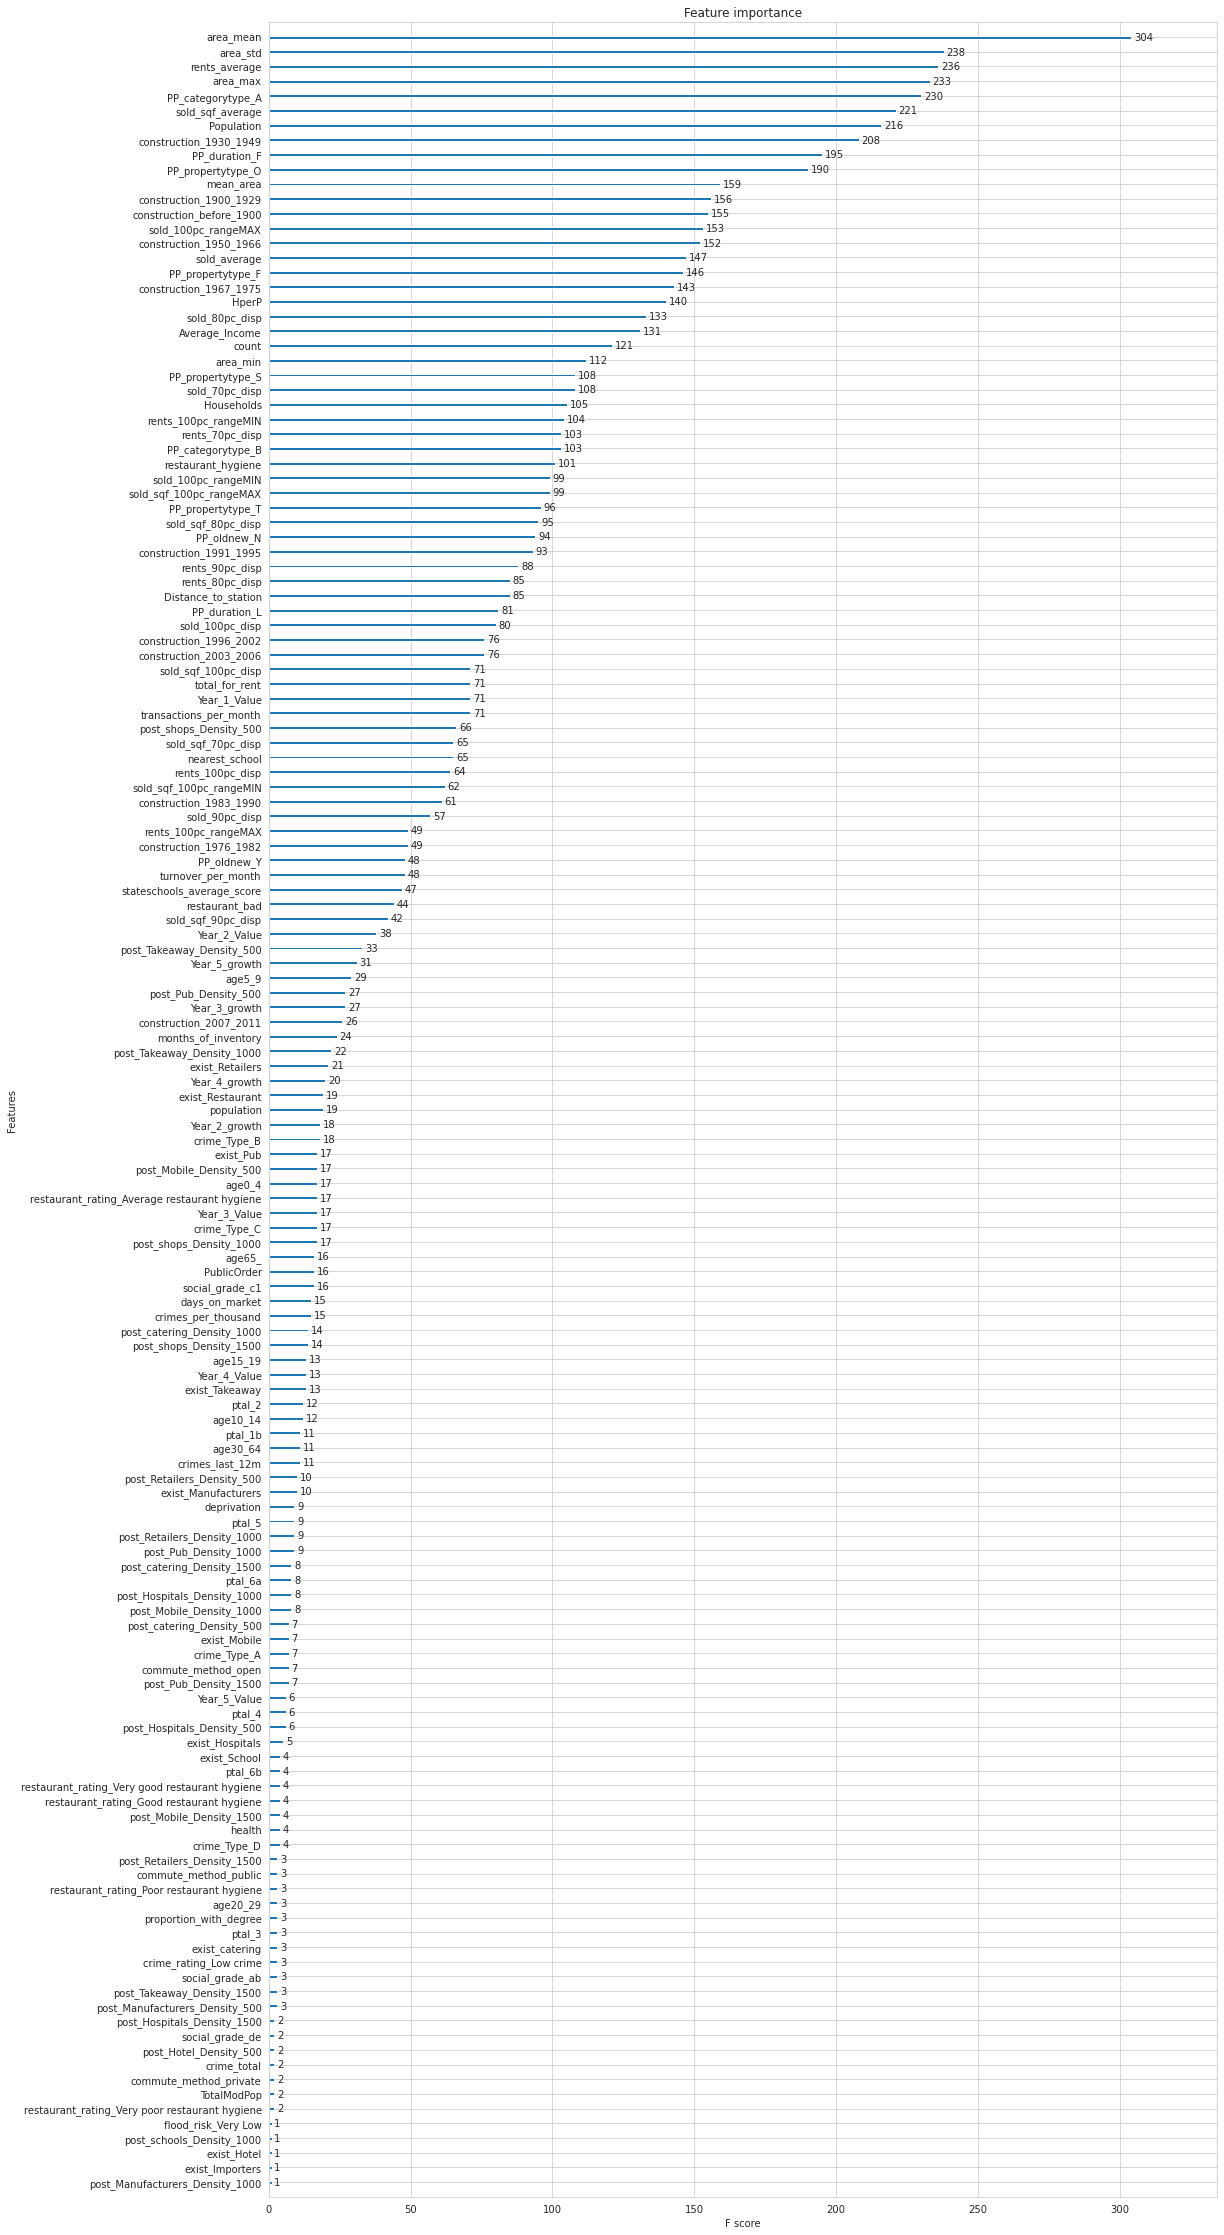

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='weight')

The following kwargs were not used by contour: 'row'
No handles with labels found to put in legend.


Text(0.5, 32.99999999999995, 'real price')

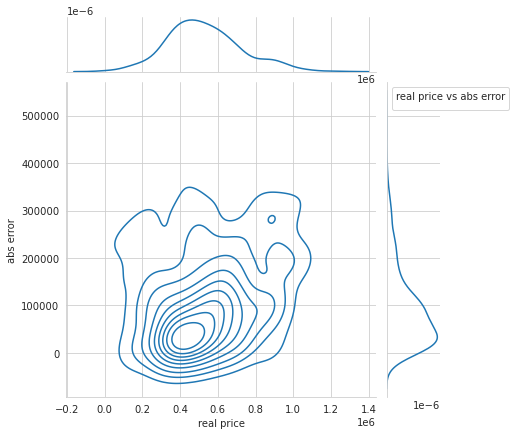

In [ ]:
h=sns.jointplot(x = test_y, y = np.abs(test_y-pred_test), kind ='kde', row="day")
plt.legend(title='real price vs abs error')
h.ax_joint.set_ylabel('abs error')
h.ax_joint.set_xlabel('real price')

No handles with labels found to put in legend.


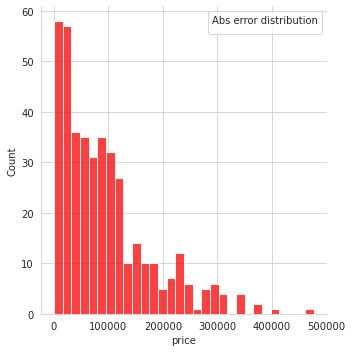

In [ ]:
sns.set_style('whitegrid')
h=sns.displot(np.abs(test_y-pred_test), kde = False, color ='red', bins = 30)
plt.legend(title='Abs error distribution')

### Explain predictions using shap

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(train_X)

Visualize a single prediction

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[100,:], train_X.iloc[100,:])

### Visualize many predictions

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], train_X.iloc[:100,:])

Bar chart of mean importance

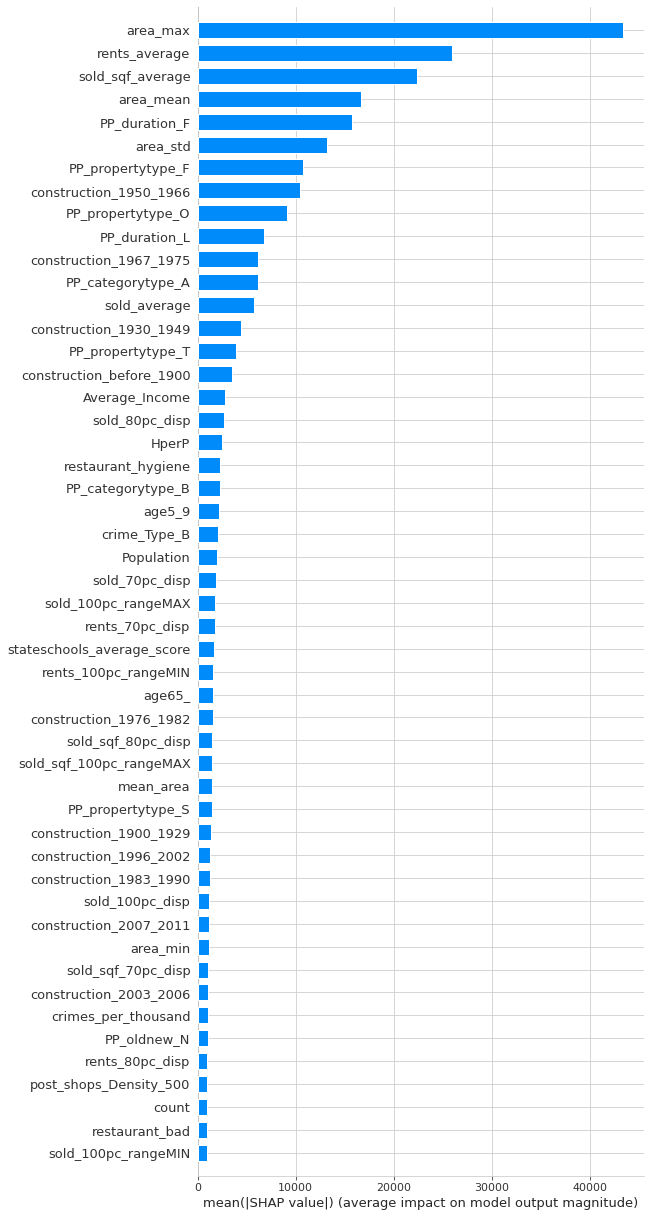

In [ ]:
shap.summary_plot(shap_values, train_X, plot_type="bar",max_display=50)

#### SHAP Summary Plot

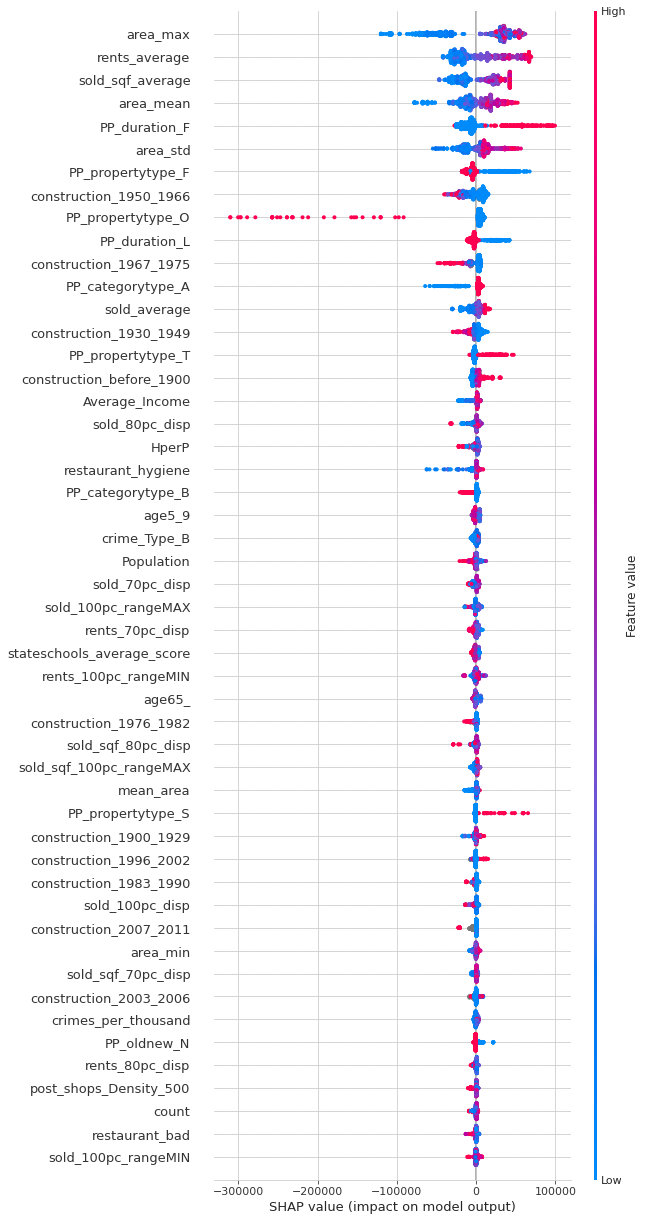

In [ ]:
shap.summary_plot(shap_values, train_X,max_display=50)

### Importance  weight in percentage

In [ ]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'weight'
L=xgb_r.get_booster().get_score(importance_type= f)

val=0
for l in L.keys():
    val +=L[l]
for l in L.keys():
    L[l]=L[l]/val
print(L)

{'area_max': 0.029241967871485943, 'sold_sqf_average': 0.027735943775100403, 'PP_propertytype_F': 0.018323293172690762, 'construction_1967_1975': 0.01794678714859438, 'HperP': 0.017570281124497992, 'PP_propertytype_O': 0.02384538152610442, 'PP_duration_F': 0.02447289156626506, 'sold_80pc_disp': 0.016691767068273092, 'construction_1983_1990': 0.007655622489959839, 'rents_average': 0.02961847389558233, 'construction_2003_2006': 0.009538152610441768, 'PP_categorytype_A': 0.02886546184738956, 'post_Takeaway_Density_500': 0.004141566265060241, 'sold_average': 0.018448795180722892, 'restaurant_hygiene': 0.01267570281124498, 'area_std': 0.029869477911646587, 'PP_duration_L': 0.01016566265060241, 'rents_100pc_rangeMIN': 0.013052208835341365, 'area_mean': 0.03815261044176707, 'Average_Income': 0.016440763052208835, 'social_grade_c1': 0.002008032128514056, 'restaurant_bad': 0.005522088353413655, 'construction_2007_2011': 0.003263052208835341, 'age5_9': 0.003639558232931727, 'construction_1950_19

### Correlation between the 30 more inportant features

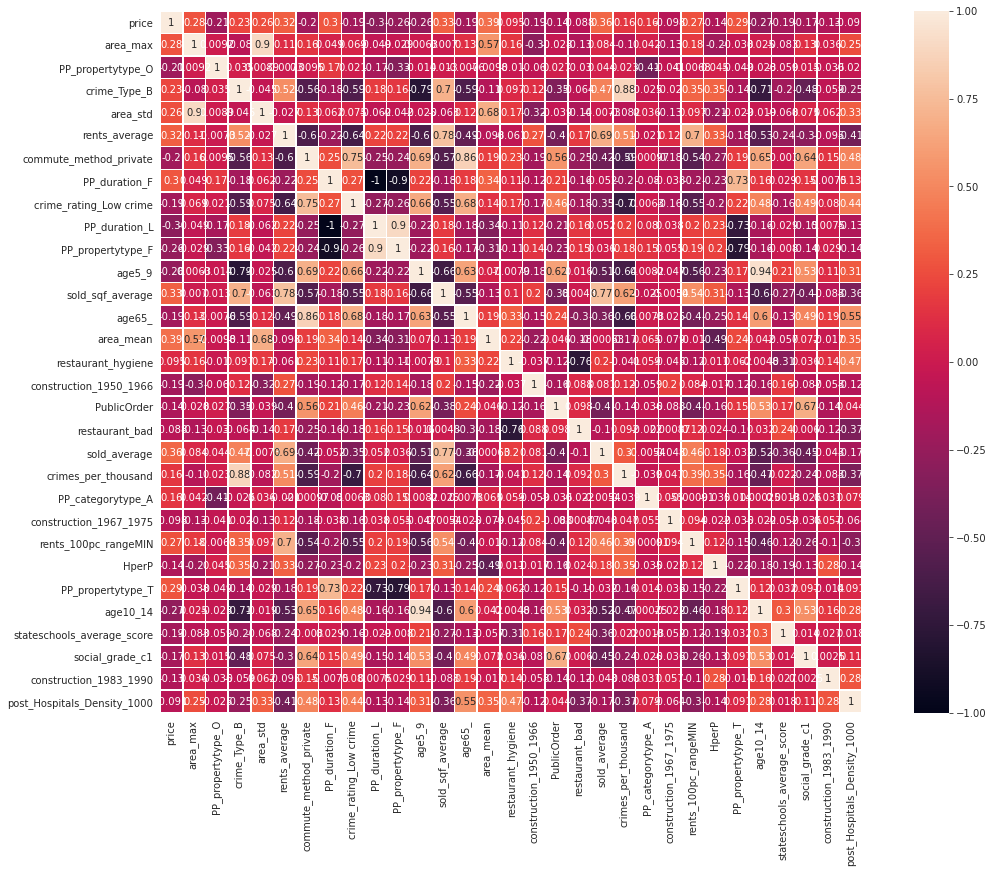

In [ ]:
results=pd.DataFrame()
results['columns']=X.columns

results['importances'] = xgb_r.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

# Heatmap of correlation matrix for Education variables:
school_chars = ['price'] + list(results['columns'][:30])
corrmat1 = Data[school_chars].corr()

plt.subplots(figsize=(18, 15))
sns.heatmap(corrmat1, square=True, linewidths=.5, annot=True)
plt.xticks(rotation='90')
plt.yticks(rotation='0')
plt.subplots_adjust(top = 0.95, bottom = 0.3, left = 0.2, right = 1)
plt.show()